In [2]:
%config IPCompleter.greedy=True

import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing, sklearn.datasets, sklearn.model_selection
import timeit
from progressbar import progressbar

So far, we have talked just about the models. I have shown you some plots and I tried to explain some phenomena on them. The results have usually seemed to be right, however, I never talked about the evaluation of the models. How to recognize, if the models are learning and performing well. I would like to correct this in this notebook.

# Loss and metric

First of all, let's talk about losses and metrices. Loss is the function, that the learning algorithm directly optimize. So far we used mean squared error loss (MSE), that is in the form $\frac{1}{n} \sum_{i=0}^{n} \left( t_i - f(\pmb{x_i}) \right)^2$. As $n$ is the constant (we have finite set of examples), optimizing it is the same as optimizing $\frac{1}{2} \sum_{i=0}^{n} \left( t_i - f(\pmb{x_i}) \right)^2$. We computed gradient of this value and optimize it directly. Before moving on, let's remind us the `Neuron` class from the last notebook.

In [3]:
class Neuron:
    def __init__(self, epochs=100, random_state=None, learning_rate=0.001, batch_size=16):
        # use epochs instead of iterations
        self.epochs = epochs
        self.converged = False
        self._rand = np.random.RandomState(random_state)
        self._weights = None
        self._learning_rate = learning_rate
        self._batch_size = batch_size
        pass
    
    def _activation(self, vals):  # activation function
        return 1 / (1 + np.exp(-vals))
    
    def fit(self, X, y, Xtest=None, ytest=None):
        # Initialize the weights
        self.converged = False
        self._weights = self._rand.uniform(-2, 2, X.shape[1])
        n_data = len(X)
        # store gradients and losses
        losses = np.zeros((self.epochs,))
        gradients = np.zeros((self.epochs, int(np.ceil(X.shape[0] / self._batch_size))))
        accuracies = np.zeros((self.epochs,))
        # Learning
        for epoch in range(self.epochs):
            # shuffle the data
            permutation = self._rand.permutation(n_data)
            # for each batch
            for batch_start in range(0, n_data, self._batch_size):
                # get batch
                batch_data = X[permutation[batch_start:batch_start+self._batch_size]]
                batch_target = y[permutation[batch_start:batch_start+self._batch_size]]
                # predict the data
                prediction = self.predict(batch_data)
                # table of gradient for each weights and gradient in the shape (samples,weights)
                gradient = np.reshape(-(batch_target - prediction) * (prediction * (1 - prediction)), newshape=(-1,1)) * batch_data
                # sum gradient over the samples
                op_gradient = self._learning_rate * np.sum(gradient, axis=0)
                # store losses and gradients
                losses[epoch] += np.sum((batch_target - prediction) ** 2, axis=0)
                gradients[epoch, int(batch_start / self._batch_size)] = op_gradient @ op_gradient
                # update the weights
                self._weights = self._weights - op_gradient
                
            # compute accuracy on the test set
            if Xtest is not None and ytest is not None:
                test_prediction = np.where(self.predict(Xtest) < 0.5, 0, 1) 
                accuracies[epoch] = np.sum(test_prediction == ytest) / len(ytest)
                
        return losses / X.shape[0], gradients, accuracies
    
    def predict(self, X):
            return self._activation(X @ self._weights)
    
    def __call__(self, X):
        return self.predict(X)

The `fit` method returns losses, gradients, and accuracies over the epochs. As we can see from the code, we compute the gradient for each example and update weights. In the end, the method returns `losses / X.shape[0]`, that is the mean loss over the whole dataset.

There is one important point to understand here - loss is independent between the examples. As the loss is the value, that is directly optimized, it should always decrease. If we had only a single example and use this algorithm, it needs to decrease every step (unless the loss is zero). However, as optimizing loss for one example can increase the loss of other examples (and loss is independent for each example), the loss of the whole dataset (mean of losses for each example) can increase.

How can we make sure this doesn't happen? We may optimize the dataset loss instead of loss per each example - that is exactly what the batch gradient descent does! Although it still computes the loss for each example, there is only one update, that takes into account all the examples. As such, it optimizes the dataset loss and the loss never increases (as you can see at the end of the previous notebook). As you may guess, using minibatch gradient descent we try to use this property using fewer examples.

Through the following notebooks, we are going to see a few more losses. Their usage depends on the task we are doing - for regression tasks (we try to predict continuous value like age, weights, and so on) we use MSE loss. For classification tasks (we try to predict in which class the example is from) we usually use cross-entropy loss function. Note that we were doing just classification so far, and we still used MSE loss. It was good enough for our purposes, but we will talk about cross-entropy soon.

Now let's talk about metrics. Metric, unlike loss, is not directly optimized during training. A decrease in loss should result in better metrics. In the last notebook, we have seen accuracy - how many examples are classified correctly. I will use accuracy to demonstrate some interesting aspects.

Unlike loss, the metric doesn't need to decrease. Especially for accuracy, the better the model, the higher accuracy you will get. The accuracy should make more sense for you are as a programmer (or as a data scientist) rather than for a computer. It may decrease, increase, oscillate around some value, and so on. It's up to you to interpret it.

Secondly, the metric is not independent between examples. Compute accuracy for a subset of the dataset doesn't make much sense. Although we may think about accuracy as the mean of values $0$ (when the prediction was wrong) and $1$ (when the prediction was correct), it doesn't need to be this way. You may see some matrices on the [tensorflow documentation page](https://www.tensorflow.org/api_docs/python/tf/keras/metrics). There are metrics like false positive, hinge, recall, and so on. The important fact is that metric, unlike loss, is some value that is aggregated over the whole dataset, rather than computed independently for each example.

And lastly, the metric is optimized indirectly. In our example, we predicted class $0$ if the value was $<0.5$ and $1$ otherwise. Take for example, that our model returned $0.7$ and we corrected it, so it returns $0.6$ (it is the class $0$). In this case, the loss decreased, but the accuracy remained the same, as the prediction is still class $1$, although it has a lower probability. This should demonstrate to you, that not only loss but why the metrics are important as well. Usually, when you have a task in hand, you are not interested in the model loss, but rather in some of it's metrics. 

# Train set, development set, and test set

We know what to measure, but we still don't know how to measure it. When we use the whole dataset for training, we don't know the real performance of the model. The problem is overfitting or underfitting, terms that I will explain in a moment. Our goal is not to get the best score on the dataset we use for training, but rather the best score on unseen data - something called **generalization error**. You may imagine it as if the model has a memory - the weights of the neuron can be used as some kind of memory. If the model can remember all the training examples and their respective target value, the error on the training set would be zero. However, when we pass examples that we didn't use for training, the prediction can be completely wrong. The problem is that the model is too much aligned with the training data and do not generalize well.

So how to get the real performance of the model? Just use the unseen data to evaluate the performance of the model. Split the dataset into **training set** and **test set**, train the model on the training set and evaluate it on the test set. The ratio is usually something between $0.7:0.3$ to $0.8:0.2$. That is exactly what I did in the previous notebooks if you read the code carefully. I used [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function from `sklearn.model_selection` namespace. You pass there array you wanna split and ratio.

In [4]:
data, target = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(data, target, test_size=0.25, random_state=47)

In [5]:
print(len(train_data), len(test_data))
print(len(train_target), len(test_target))

52500 17500
52500 17500


Now we have train data and test data and we may measure the performance of the model. There is however one drawback - the model has some parameters, that we need to set up. For us, this can be learning rate, batch size, or number of epochs. These are not parameters that are learned during training but we need to set them up in advance - they are called **hyperparameters**. No one is so skilled that he could guess the parameters correctly, there is usually some experimenting and searching for those parameters. We may use the test set and pick up the combination of hyperparameters, that have the lowest test error. But that brings us back where we were before - how to measure the real performance of the model. We used the test set to set up hyperparameters, so obviously, it's the best model that performs on the test set. But what about unseen data, is it still the case?

What seems to be a good idea is split data into three parts - **training set** that we use for training and we use it to set up trainable parameters (like weights). Then we use **development set** for hyperparameter search - based on the performance on the development set we pick up the best model. Finally, we use **test set** to evaluate the performance of the model on unseen data.

This approach has one drawback - we reduced the amount of training data significantly. From the whole dataset, we use only a fraction for the training - usually something between 60% and 70%. Still, it seems this approach has the best performance estimation so far. In a moment I will talk about *K-fold cross validation*, that doesn't use the validation set per se, but is computably much more intensive.

There is no build-in function to split data into training, validation, and test set. However, we may use `train_test_split` twice. FOr example to split data in ratio $0.6:0.2:0.2$ we may use the following code.

In [6]:
train_data, devtest_data, train_target, devtest_target = sklearn.model_selection.train_test_split(data, target, test_size=0.4, random_state=47)
dev_data, test_data, dev_target, test_target = sklearn.model_selection.train_test_split(devtest_data, devtest_target, test_size=0.5, random_state=47)
print(len(train_data), len(dev_data), len(test_data))
print(len(train_target), len(dev_target), len(test_target))

42000 14000 14000
42000 14000 14000


# Underfitting, overfitting and model capacity

Now, when we know how to measure the performance of the model, we may talk about underfitting and overfitting. There is something that we call **model capacity** - that is how much the model can remember. If the task at hand is something complicated, we need a model with higher capacity, as it needs to remember more about the problem itself. That is at least from the generic point of view. I will show an example in a minute.

When we have a task at hand, how do we know if the model has the correct capacity? And how we even recognize, that we capacity is the right one? We may see two phenomena - underfitting and overfitting. **Underfitting** is the case, when the capacity is too small and the model can't fully learn the problem in hand (or doesn't learn it yet). In this case, the validation error is usually lower than the training error, but the training error is not decreasing any more. The opposite problem is **overfitting** - the capacity of the model is too high and during training, the model is aligned too much to the example data. This is the case when the training error is decreasing whereas the validation error is increasing.

The traditional data scientists are using the following picture to demonstrate this phenomenon.

<img src="https://upload.wikimedia.org/wikipedia/commons/1/1f/Overfitting_svg.svg" alt="Overfitting demonstration" width="600"/>

On the left from the exclamation mark, the model is underfitting, because it still didn't learn enough to predict correctly. On the right side, the model is already overfitting and the development error is increasing. The exclamation mark is at the place, where the development error is the lowest. That is the point during training, from which we should take the model.

This approach works better when traditional models are used. In neural networks we have a number of tools on how to decrease or increase the capacity of the model - there are called regularization techniques and we will talk about them extensively later on. I believe it is better to align the model capacity with the problem in hand and properly train the model rather than using snapshot somewhere from the beginning of the training.

There is usually one more example, that demonstrates the underfitting and overfitting. Let's say we have some data points and we want to separate them.

<img src="https://raw.githubusercontent.com/alexeygrigorev/wiki-figures/master/legacy/overfit-dataset.png" alt="Dataset" width="300"/>

We may use different models - linear, quadratic, or polynomial of a higher order. What would be the best separation line?

<img src="https://raw.githubusercontent.com/alexeygrigorev/wiki-figures/master/ufrt/kddm/overfitting-logreg-ex.png" alt="Dataset separation" width="900" />

The first model, the linear one, couldn't properly separate the data. The model is underfitting because it doesn't have enough capacity to solve the problem at hand. The quadratic model, the second, separates the data nicely, although there are some red crosses outliers. That is OK, the generalization error itself as probably the best we can get. Finally, the last model is overfitting - it tries too much to predict all the examples correctly and in the end, it remembered that the two outliers (the red crosses) are in the correct class. It was able to learn it as it has enough capacity to remember these two examples directly. As a result, the model is overfitting and the generalization error is probably worse than in the middle case.

As I already said, we will talk about regularization - that is reducing the capacity of the model later on.

# K-fold cross-validation

There is one approach, that we may use when there is not enough data. We split the data into subsets of the same size (we usually use from 5 to 7 subsets) called folds and always use one fold as a validation set. That mean we will train the model five times if we split data into 5 subsets - also called 5-fold cross-validation. Each model will use different fold as a validation set - that means the first model will use the first fold as a validation set and the rest folds as training sets, the second model will use the second fold as a validation set and rest of them (including the first one) as a training set and so on. We get losses and metrics from each model and average them to get the real score of the model.

For k-fold we may use [`sklearn.model_selection.KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class from `sklearn` library. Let's demonstrate it. Firstly, I will download the data and preprocess them the same way as in the previous notebook.

In [7]:
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(int)
one_or_seven_indices = np.logical_or(y == 4, y == 9)
data = X[one_or_seven_indices].reshape(-1, 784)
data[data < 128] = 0
data[data > 0] = 1
data = np.hstack([data, np.ones((data.shape[0],1))])
target = y[one_or_seven_indices].reshape(-1)
target[target==4] = 0
target[target==9] = 1

Now let's use k-fold cross-validation to obtain the scores.

In [8]:
from sklearn.model_selection import KFold

losses = []
accuracies = []

for train_indices, test_indices in KFold(n_splits=5, random_state=47, shuffle=True).split(data):
    train_data, train_target = data[train_indices], target[train_indices]
    test_data, test_target = data[test_indices], target[test_indices]
    model = Neuron(epochs=400, random_state=47, learning_rate=0.001, batch_size=64)
    loss, _, acc = model.fit(train_data, train_target, test_data, test_target)
    losses.append(loss)
    accuracies.append(acc)

We have list of losses and accuracies between the folds. Finally, let's plot them.

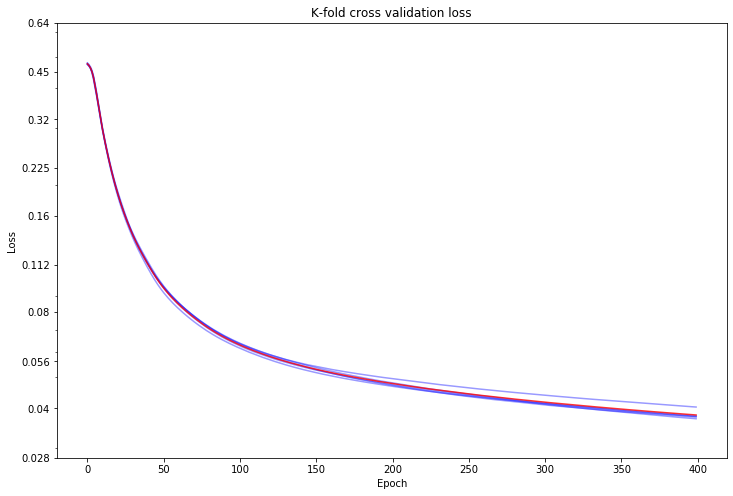

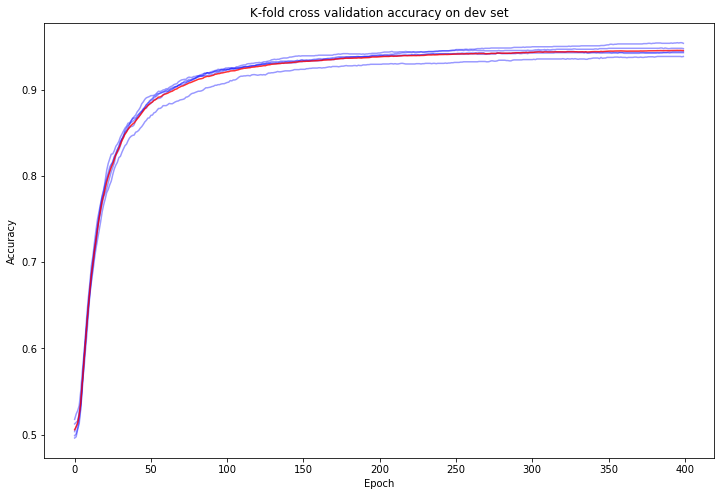

In [9]:
plt.figure(figsize=(12,8))
for l in losses:
    plt.plot(l, alpha=0.4, color='blue')
plt.plot(np.mean(losses, axis=0), alpha=0.8, color='red')
plt.yscale('log')
ticks = [0.028, 0.04, 0.056, 0.08, 0.112, 0.16, 0.225, 0.32, 0.45, 0.64]
plt.yticks(ticks=ticks, labels=ticks)
plt.title('K-fold cross validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


plt.figure(figsize=(12,8))
for a in accuracies:
    plt.plot(a, alpha=0.4, color='blue')
plt.plot(np.mean(accuracies, axis=0), alpha=0.8, color='red')
plt.title('K-fold cross validation accuracy on dev set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

As you may see, although some of the runs were better and some worse, by using the mean of all the folds we get quite a good picture of the performance of the algorithm. What is best, we used all the data. We may use K-fold cross-validation to search for hyperparameters and when we found them, we may use all the data to train the model. That means we still need a test set!! By using K-fold cross-validation, we get rid only of the development set, but the final evaluation of the model must be done on data, that the model has never seen in any way (including the indirect one, that we used for hyperparameter search).

So that is K-fold cross-validation. As you may guess, there is a huge drawback - we need to train the model five times. This is reasonable in traditional data science, where models don't learn for so long. However, when we will be talking about some of the bigger neural networks, they are usually trained hours, days, some of them even weeks. Train these models multiple times, especially during hyperparameter search, when we need to test some amount of hyperparameter combinations is not reasonable. Because of this, K-fold cross-validation is not usually done with neural networks. I thought it may be good you know about it, in case you don't have much data, but in most of the cases, using the train, dev, and test set is the way to go.

# Refactoring

Before we move on to the next notebook, let's refactor our class a little bit. When we have our train and test data:

In [10]:
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(int)
one_or_seven_indices = np.logical_or(y == 4, y == 9)
data = X[one_or_seven_indices].reshape(-1, 784)
data[data < 128] = 0
data[data > 0] = 1
data = np.hstack([data, np.ones((data.shape[0],1))])
target = y[one_or_seven_indices].reshape(-1)
target[target==4] = 0
target[target==9] = 1
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(data, target, test_size=0.3, random_state=47)

We will use separate classes for losses and metrics. We will use this to use different losses or matrices in the following notebooks. The loss will have a method to compute it (`__call__` method) and a method that computes the gradient (`gradient` method). These methods will receive only target values and predicted values as parameters. 

The metrics are designed the same, but we need to allow them to accumulate the metric over the whole dataset. We will use `__call__` method to update the metric and `summary` method that should return the final metric after the epoch.

You can see an example of `MSELoss` and `AccuracyMetric` classes bellow.

In [11]:
class MSELoss:
    def __call__(self, target, predicted):
        return np.sum((target - predicted) ** 2, axis=0)
    def gradient(self, target, predicted):
        return -(target - predicted)

class AccuracyMetric:
    def __init__(self, name=None):
        self.name = name or "accuracy"
        self.correct = 0
        self.num = 0
    def __call__(self, target, predicted):
        self.correct += np.sum((predicted >= 0.5) & (target == 1)) + np.sum((predicted < 0.5) & (target == 0))
        self.num += len(target)
    def summary(self):
        acc = self.correct / self.num
        self.correct = 0
        self.num = 0
        return acc

Finally, let's refactor our `Neuron` class. We pass loss and metrics list as parameters to the constructor. We will calculate loss and metrics for both train and test set (when provided) and return them from the `fit` method in a dictionary. Moreover, I will allow logging progress of the training.

In [12]:
class Neuron:
    def __init__(self, loss, metrices=[], epochs=100, random_state=None, learning_rate=0.001, batch_size=16):
        self.epochs = epochs
        self.loss = loss
        self.metrices = metrices
        self._rand = np.random.RandomState(random_state)
        self._weights = None
        self._learning_rate = learning_rate
        self._batch_size = batch_size
        pass
    
    def _activation(self, vals):  # activation function
        return 1 / (1 + np.exp(-vals))
    
    def fit(self, X, y, Xtest=None, ytest=None, progress=False):
        # Initialize the weights
        self._weights = self._rand.uniform(-2, 2, X.shape[1])
        # get how many data we have
        n_train_data = len(X)
        n_test_data = 1 if ytest is None else len(ytest)
        # store gradients and losses
        train_losses = np.zeros((self.epochs,))
        test_losses = np.zeros((self.epochs,))
        train_metrices = np.zeros((len(self.metrices), self.epochs))
        test_metrices = np.zeros((len(self.metrices), self.epochs))
        # decide whatever to log progress
        epoch_counter = progressbar(range(self.epochs)) if progress else range(self.epochs)
        # Learning
        for epoch in epoch_counter:
            # shuffle the data
            permutation = self._rand.permutation(n_train_data)
            # for each batch
            for batch_start in range(0, n_train_data, self._batch_size):
                # get batch
                batch_data = X[permutation[batch_start:batch_start+self._batch_size]]
                batch_target = y[permutation[batch_start:batch_start+self._batch_size]]
                # predict the data
                prediction = self.predict(batch_data)
                # table of gradient for each weights and gradient in the shape (samples,weights)
                gradient = np.reshape(self.loss.gradient(batch_target, prediction) * (prediction * (1 - prediction)), newshape=(-1,1)) * batch_data
                # sum gradient over the samples
                op_gradient = self._learning_rate * np.sum(gradient, axis=0)
                # store loss
                train_losses[epoch] += self.loss(batch_target, prediction)
                # update the weights
                self._weights = self._weights - op_gradient
                # transform probs to predictions
                prediction[prediction < 0.5] = 0
                prediction[prediction >= 0.5] = 1
                # compute the metrices
                for metric in self.metrices:
                    metric(batch_target, prediction)
            # store train metrices
            for num_metric, metric in enumerate(self.metrices):
                train_metrices[num_metric, epoch] = metric.summary()
                
            # evaluate on the test set
            if Xtest is not None and ytest is not None:
                # for each batch
                for batch_start in range(0, n_test_data, self._batch_size):
                    # get batch
                    batch_data = Xtest[batch_start:batch_start+self._batch_size]
                    batch_target = ytest[batch_start:batch_start+self._batch_size]
                    # predict the data
                    prediction = self.predict(batch_data)
                    # store loss
                    test_losses[epoch] += self.loss(batch_target, prediction)
                    # transform probs to predictions
                    prediction[prediction < 0.5] = 0
                    prediction[prediction >= 0.5] = 1
                    # compute the metrices
                    for metric in self.metrices:
                        metric(batch_target, prediction)
                # store test metrices
                for num_metric, metric in enumerate(self.metrices):
                    test_metrices[num_metric, epoch] = metric.summary()
          
        results = {
            "train_loss": train_losses / n_train_data, 
            "test_loss": test_losses / n_test_data,      
        }
        results.update({f"train_{metric.name}": train_metrices[num_metric] for num_metric in range(len(self.metrices))})
        results.update({f"test_{metric.name}": test_metrices[num_metric] for num_metric in range(len(self.metrices))})
        return results
    
    def predict(self, X):
        return self._activation(X @ self._weights)
        
    def predict_classes(self, X):
        prediction = self.predict(X)
        prediction[prediction < 0.5] = 0
        prediction[prediction >= 0.5] = 1
    
    def __call__(self, X):
        return self.predict(X)

Let's try to use the modified class.

In [13]:
model = Neuron(loss=MSELoss(), metrices=[AccuracyMetric()], epochs=1000, random_state=47, learning_rate=0.001, batch_size=64)
results = model.fit(train_data, train_target, test_data, test_target, progress=True)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:58 Time:  0:00:58


Finally, let's plot the reults.

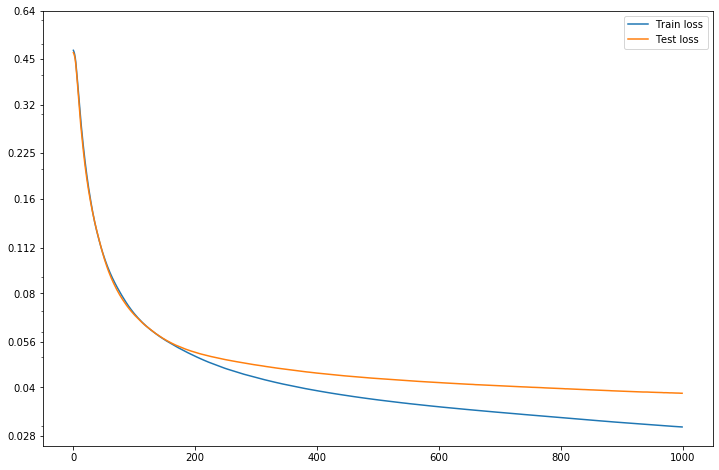

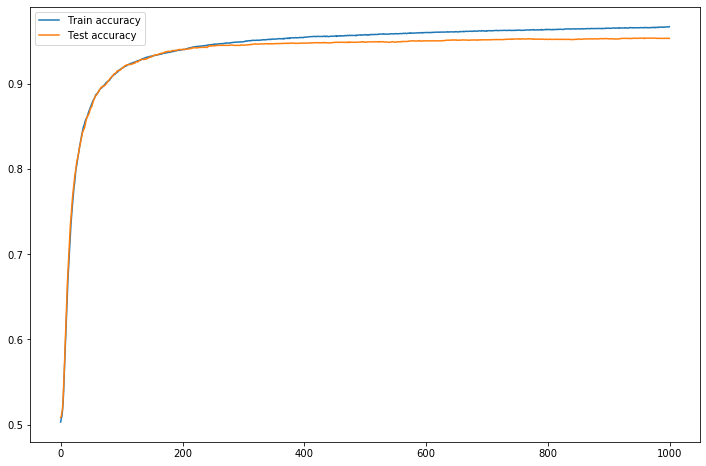

In [14]:
plt.figure(figsize=(12,8))
plt.plot(results['train_loss'], label="Train loss")
plt.plot(results['test_loss'], label="Test loss")
plt.yscale('log')
ticks = [0.028, 0.04, 0.056, 0.08, 0.112, 0.16, 0.225, 0.32, 0.45, 0.64]
plt.yticks(ticks=ticks, labels=ticks)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(results['train_accuracy'], label="Train accuracy")
plt.plot(results['test_accuracy'], label="Test accuracy")
plt.legend()
plt.show()

What we may see? The method is not overfitting, as the test loss is not increasing. However, the test loss and test accuracy is worse compare to training ones. We should probably increase the capacity of the model and use regularization, which doesn't degrade its' capacity. I will show you how to do it later on.